# Graph Evolution

Graph evolution for given algorithms and dataset.

In [1]:
import os
import urllib.request
import random
import time
import leidenalg
import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
from igraph import Graph

# required helper files
import graph_evolution_metrics as metrics

# Seed for reproducibility
random.seed(42)

In [2]:
## CHANGE TO MATCH ALG AND DATASET

# Module of alg being used
import nodesim as alg

# Name of dataset being used
# Directed: wiki_vote, congress, email_eu
# Undirected: facebook, deezer, lastfm

BASENAME, DIRECTED = "wiki_vote", True
# BASENAME, DIRECTED = "congress", True
# BASENAME, DIRECTED = "email_eu", True
# BASENAME, DIRECTED = "facebook", False
# BASENAME, DIRECTED = "deezer", False
# BASENAME, DIRECTED = "lastfm", False

In [3]:
## PARAMS

# Graph Evolution
ITERATIONS = 30

# Community Detection Threshold
COMM_THRESHOLD = 2

In [4]:
# Constants for I/O

BASE_URL = "https://raw.githubusercontent.com/jasonTheDev/link-rec-networks/main/"
INPUT_DIR = "input"
OUTPUT_DIR = "data"

OUTPUT_PREFIX = BASENAME + "." + alg.__name__

CLUSTERING_PATH = os.path.join(OUTPUT_DIR, OUTPUT_PREFIX + ".clu")
GINI_PATH = os.path.join(OUTPUT_DIR, OUTPUT_PREFIX + ".gin")
VISIBILITY_PATH = os.path.join(OUTPUT_DIR, OUTPUT_PREFIX + ".vis")
SUMMARY_PATH = os.path.join(OUTPUT_DIR, OUTPUT_PREFIX + ".sum")
PLOT_PATH = os.path.join(OUTPUT_DIR, OUTPUT_PREFIX + ".png")

EDGELIST = BASENAME + ".txt"
EDGELIST_PATH = os.path.join(INPUT_DIR, EDGELIST)

if DIRECTED:
    RAW_URL = os.path.join(BASE_URL, "directed/" + EDGELIST)
else:
    RAW_URL = os.path.join(BASE_URL, "undirected/" + EDGELIST)

In [5]:
# Create input and output directories
if not os.path.isdir(INPUT_DIR):
    os.makedirs(INPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Download file if it doesn't exist
if not os.path.isfile(EDGELIST_PATH):
    print(f"Downloading: {EDGELIST}")
    urllib.request.urlretrieve(RAW_URL, EDGELIST_PATH)
else:
    print("Already downloaded")

file_list = os.listdir(INPUT_DIR)
print(file_list)

Already downloaded
['congress.txt', 'deezer.txt', 'email_eu.txt', 'facebook.txt', 'lastfm.txt', 'wiki_vote.txt']


In [6]:
# directed and undirected graphs respond to same API

class UndirectedGraph(nx.Graph):
    """
    Wrapper for NetworkX undirected graph.
    """
    def successors(self, node):
        return self.neighbors(node)

    def in_degree(self, node):
        return self.degree(node)
        
    def out_degree(self, node):
        return self.degree(node)
    
    def get_communities(self):
        return nx_comm.louvain_communities(self)


class DirectedGraph(nx.DiGraph):
    """
    Wrapper for NetworkX directed graph.
    """
    def get_communities(self):
        # convert to igraph
        G_igraph = Graph.TupleList(self.edges(), directed=True)
        part = leidenalg.find_partition(G_igraph, leidenalg.ModularityVertexPartition)

        # dict
        comms_dict = {}
        for i, comm in enumerate(part.membership):
            if comm not in comms_dict:
                comms_dict[comm] = []
            comms_dict[comm].append(i)

        # list
        comms = []
        for comm in comms_dict.values():
            comms.append(comm)
        
        return comms

In [7]:
if DIRECTED:
    init_g = nx.read_edgelist(EDGELIST_PATH, create_using=nx.DiGraph(), nodetype=int)
    init_g = DirectedGraph(init_g)
else:
    init_g = nx.read_edgelist(EDGELIST_PATH, create_using=nx.Graph(), nodetype=int)
    init_g = UndirectedGraph(init_g)
print(init_g)

DirectedGraph with 7115 nodes and 103689 edges


## Network Evolution Following Wagner's Methods

In [8]:
def random_edge_per_node(nx_g):
    """
    Returns a list of random outgoing edges per node
    where both nodes have degree > 1.
    """
    removals = []
    nodes = list(nx_g.nodes())
    random.shuffle(nodes)
    for node in nodes:
        if nx_g.out_degree(node) > 1:
            successors = list(nx_g.successors(node))
            random.shuffle(successors)
            for successor in successors:
                if nx_g.in_degree(successor) > 1:
                    removals.append((node, successor))
                    break
    return removals

    
# IMPORTANT: we do deletions to keep a baseline for the clustering coefficient and 
# see the effect of the algorithm on the graphs structure
def evolve_network(nx_g, minority_nodes):
    """
    Iteratively evolve the network by adding and removing edges.
    """
    # initial metrics
    ginis = [metrics.gini_of_degree_distribution(nx_g)]
    clusters = [nx.average_clustering(nx_g)]
    visibilities = [metrics.pagerank_visibility(nx_g, minority_nodes)]

    # prepare for algorithm
    nx_g = alg.initialize(nx_g)

    print("Iteration")
    print(f"0: {nx_g}")

    for i in range(1, ITERATIONS+1):

        predictions = alg.predict(nx_g)
        nx_g.add_edges_from(predictions)

        removals = random_edge_per_node(nx_g)
        nx_g.remove_edges_from(removals)

        # compute metrics
        ginis.append(metrics.gini_of_degree_distribution(nx_g))
        clusters.append(metrics.average_clustering(nx_g))
        visibilities.append(metrics.pagerank_visibility(nx_g, minority_nodes))
  
        if i % 2 == 0:
            print(f"{i}: {nx_g}")
    
    return ginis, clusters, visibilities

In [9]:
# find the minority nodes
comms = init_g.get_communities()

comms_above_threshold = [c for c in comms if len(c) > COMM_THRESHOLD]

# find the median size of the communities
median_size = np.median([len(c) for c in comms_above_threshold])

minority_nodes = []
majority_nodes = []

for comm in comms:
    if len(comm) < median_size:
        minority_nodes.extend(comm)
    else:
        majority_nodes.extend(comm)

print("Median size of communities: ", median_size)
print(f"Minority size: {len(minority_nodes)}")
print(f"Majority size: {len(majority_nodes)}")

Median size of communities:  4.0
Minority size: 55
Majority size: 7060


In [10]:
# evolve the network
start = time.time()
ginis, clusters, visibilities = evolve_network(init_g, minority_nodes)
end = time.time()
print(f"Time elapsed: {end - start}")

Iteration
0: DirectedGraph with 7115 nodes and 103689 edges
2: DirectedGraph with 7115 nodes and 104723 edges
4: DirectedGraph with 7115 nodes and 104732 edges
6: DirectedGraph with 7115 nodes and 104732 edges
8: DirectedGraph with 7115 nodes and 104734 edges
10: DirectedGraph with 7115 nodes and 104735 edges
12: DirectedGraph with 7115 nodes and 104735 edges
14: DirectedGraph with 7115 nodes and 104735 edges
16: DirectedGraph with 7115 nodes and 104737 edges
18: DirectedGraph with 7115 nodes and 104737 edges
20: DirectedGraph with 7115 nodes and 104738 edges
22: DirectedGraph with 7115 nodes and 104738 edges
24: DirectedGraph with 7115 nodes and 104741 edges
26: DirectedGraph with 7115 nodes and 104742 edges
28: DirectedGraph with 7115 nodes and 104742 edges
30: DirectedGraph with 7115 nodes and 104742 edges
Time elapsed: 1018.4339196681976


## Results
### Coefficients

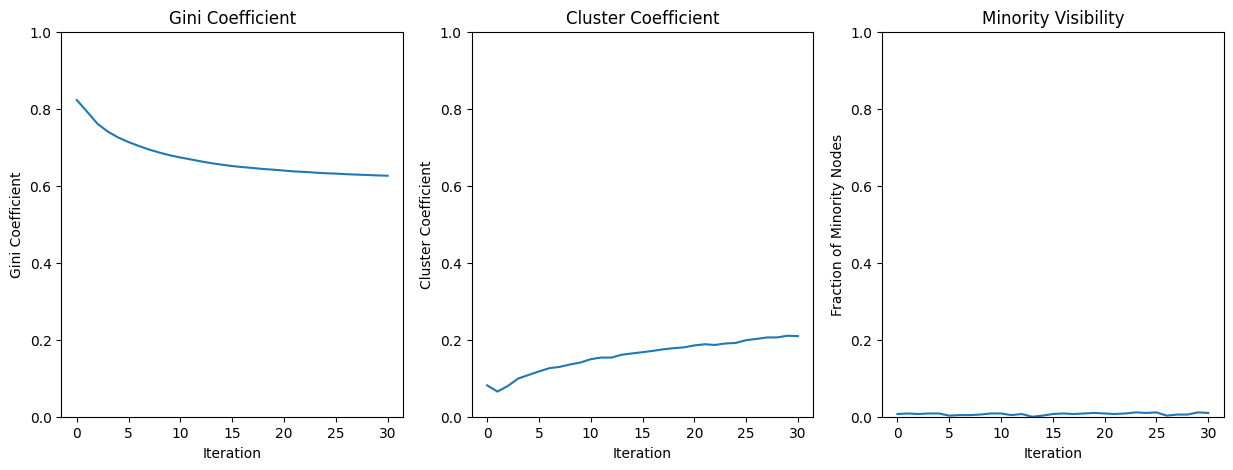

In [11]:
# plot data
metrics.plot_to_file(PLOT_PATH, ginis, clusters, visibilities)

## Write to Files

In [12]:
# write gini_coefficient to file
metrics.list_to_file(GINI_PATH, ginis)

In [13]:
# write gini_coefficient to file
metrics.list_to_file(CLUSTERING_PATH, clusters)

In [14]:
# write visibilities to file
metrics.list_to_file(VISIBILITY_PATH, visibilities)

In [15]:
with open(SUMMARY_PATH, 'w') as f:
    f.write(f"Iterations: {ITERATIONS}\n")
    f.write(f"Total number of nodes: {init_g.number_of_nodes()}\n")
    f.write(f"Number of communities detected: {len(comms)}\n")
    f.write(f"Number of communities above threshold: {len(comms_above_threshold)}\n")
    f.write(f"Median size of communities above threshold: {median_size}\n")
    f.write(f"Minority size: {len(minority_nodes)}\n")